In [19]:
# data preprocessing
#from google.colab import drive # 從google drive input data
#drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt 
#train_x, train_y = np.load('drive/MyDrive/fashion_mnist/train_x.npy'), np.load('drive/MyDrive/fashion_mnist/train_y.npy')
#test_x, test_y = np.load('drive/MyDrive/fashion_mnist/test_x.npy'), np.load('drive/MyDrive/fashion_mnist/test_y.npy')
train_x, train_y = np.load('fashion_mnist/train_x.npy'), np.load('fashion_mnist/train_y.npy')
test_x, test_y = np.load('fashion_mnist/test_x.npy'), np.load('fashion_mnist/test_y.npy')
# load data
#checkpoint = np.load('drive/MyDrive/weights.npy', allow_pickle=True).item()
checkpoint = np.load('weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w'] # 權重初始值
init_biases = checkpoint['b'] # bias初始值


def one_hot (x):  # 將label換成one hot格式
    y = np.zeros((x.size, 5))
    for idx, row in enumerate(y):
        row[x[idx]] = 1
    return y
train_y = one_hot(train_y)
test_y  = one_hot(test_y)
train_x = train_x / 255 # 歸依化
test_x  = test_x  / 255


In [2]:
# define needed func
def relu(x): 
    return np.maximum(0, x)

def relu_grad(z):
    z[z > 0] = 1
    z[z <= 0] = 0
    return z

def cross_entropy(y, t):    # 這裡沒有corss_entropy和softmax的gradient因為這兩個可以消掉
    if y.ndim == 1:        #  變成(y-t/個數)這個漂亮的形式
        t = t.reshape(1, t.size)        
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]    
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

In [4]:
# 1(a) model structure
class HungNet: 
    def __init__(self, init_weights ,init_biases ):
        self.params = {}  # 使用給定權重，分別加入字典
        self.params['W1'] = np.array(init_weights[0])
        self.params['b1'] = np.array(init_biases[0])
        self.params['W2'] = np.array(init_weights[1])
        self.params['b2'] = np.array(init_biases[1])
        self.params['W3'] = np.array(init_weights[2])
        self.params['b3'] = np.array(init_biases[2])


    def predict(self, x):        
        W1, W2 ,W3 = self.params['W1'], self.params['W2'], self.params['W3']  
        b1, b2 ,b3 = self.params['b1'], self.params['b2'], self.params['b3']
        a1 = np.dot(x, W1) + b1        # 使用字典中的權重算forward
        z1 = relu(a1)        
        a2 = np.dot(z1, W2) + b2        
        z2 = relu(a2)
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)
        return y
    
       
    def gradient(self, x, t):
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']
        
        grads = {} 
        
        # feed forward 先算forward取得各節點參數值
        batch_num = x.shape[0]   
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) + b2
        z2 = relu(a2)
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)     
       
        # backward propagation
        dy = (y - t) / batch_num 
        
        grads['W3'] = np.dot(z2.T, dy) # 注意transpose以及矩陣維度
        grads['b3'] = np.sum(dy, axis=0)
        dz2 = np.dot(dy, W3.T)
        da2 = relu_grad(z2) * dz2   
        
        grads['W2'] = np.dot(z1.T, da2)
        grads['b2'] = np.sum(da2, axis=0)        
        dz1 = np.dot(da2, W2.T)
        da1 = relu_grad(z1) * dz1
        
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)
        return grads


    def loss(self, x, t):
        y = self.predict(x) # x:train_data, t:t
        
        return cross_entropy(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / (x.shape[0])
        return accuracy

In [5]:
# 1(a) training
#%% exe training
train_loss_list=[] # 設定空list用以畫圖
test_loss_list=[]
train_acc_list=[]
test_acc_list=[]
epoch=0
#%%
# Hyperparameters Settings 使用題目給定要求超參數
iters_num = 150*20 
train_size = 30000
batch_size= 200
learning_rate=0.001
network = HungNet(init_weights,init_biases) # 傳入class的是給定權重和bias
iter_per_epoch = 150 # 每個epoch的iterations數
plot_iter = 50 # 每50iterations取一次值畫圖
for i in range(iters_num):
    batch_mask=[]
    for j in range((i%150)*200,(1+(i%150))*200):
        batch_mask.append(j) # 從30000筆拿出200筆
    x_batch=train_x[batch_mask] # (200,784)
    y_batch=train_y[batch_mask] # (200,5)

    grad=network.gradient(x_batch,y_batch) 
 
    for key in ('W1','b1','W2','b2','W3','b3'): # 利用字典改參數
        network.params[key]-=learning_rate * grad[key] # change weights and biases
 
    if (i+1)%plot_iter==0: # 每50 iterations
        if (i+1)%iter_per_epoch==0: # 每150 iterations
          epoch+=1
          print('epoch'+str(epoch))
          if (i+1)==iters_num: # 最後print
              print('epoch '+str(epoch)+': '+' train_acc '+str(train_acc)+', test_acc  '+str(test_acc)+', train_loss  '+str(train_loss)+', test_loss  '+str(test_loss))
        train_loss=network.loss(train_x,train_y)
        test_loss=network.loss(test_x,test_y)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc=network.accuracy(train_x,train_y)
        test_acc=network.accuracy(test_x,test_y)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
       


model_1a = network.params

epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
epoch10
epoch11
epoch12
epoch13
epoch14
epoch15
epoch16
epoch17
epoch18
epoch19
epoch20
epoch 20:  train_acc 0.9897666666666667, test_acc  0.9724, train_loss  0.16323234447392035, test_loss  0.4448591312566081


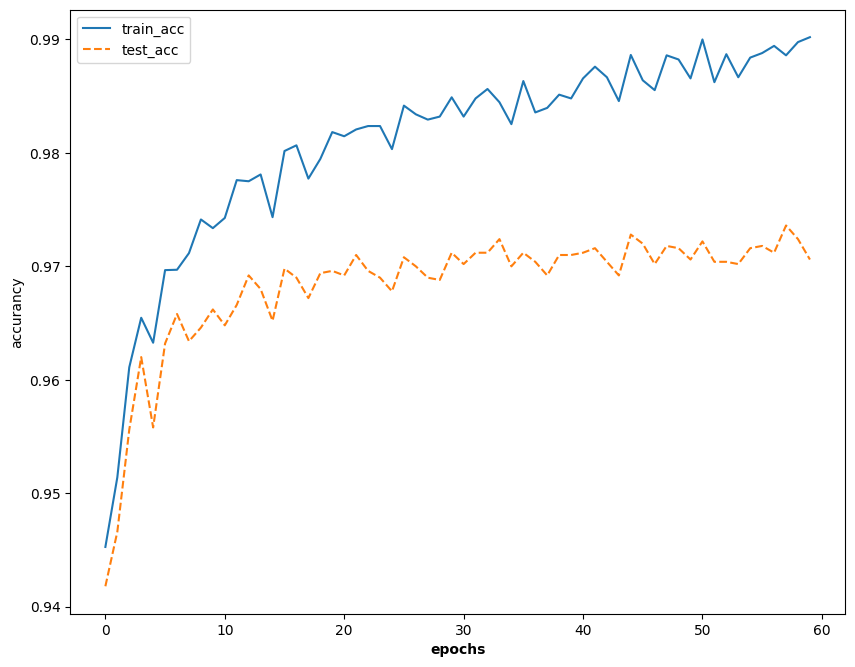

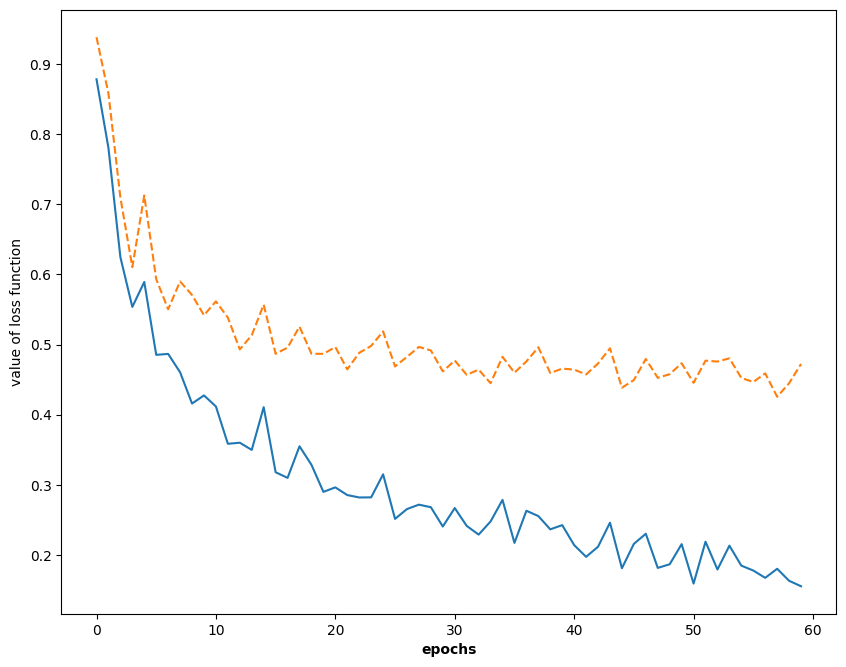

In [80]:
# 1(a) plot
import matplotlib.pyplot as plt
x=range(len(train_acc_list))
y1=train_acc_list
y2=test_acc_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_acc')
plt.plot(x,y2,linestyle='--',label='test_acc')
plt.xlabel('epochs', fontweight="bold")
plt.ylabel('accurancy')
plt.legend()
plt.show()
 

# plt loss
x=range(len(train_loss_list))
y1=train_loss_list
y2=test_loss_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_acc')
plt.plot(x,y2,linestyle='--',label='test_acc')
plt.xlabel('epochs', fontweight="bold")
plt.ylabel('value of loss function')
plt.show()

In [81]:
# 1(b) weights zero initialization
class HungNet: 
    def __init__(self, init_weights ,init_biases ):
        self.params = {}
        self.params['W1'] = np.zeros(init_weights[0].shape) # 權重和biases都設零
        self.params['b1'] = np.array(init_biases[0])
        self.params['W2'] = np.zeros(init_weights[1].shape)
        self.params['b2'] = np.array(init_biases[1])
        self.params['W3'] = np.zeros(init_weights[2].shape)
        self.params['b3'] = np.array(init_biases[2])


    def predict(self, x):        
        W1, W2 ,W3 = self.params['W1'], self.params['W2'], self.params['W3']  
        b1, b2 ,b3 = self.params['b1'], self.params['b2'], self.params['b3']
        a1 = np.dot(x, W1) + b1        # 使用字典中的權重算forward
        z1 = relu(a1)        
        a2 = np.dot(z1, W2) + b2        
        z2 = relu(a2)
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)
        return y
    
       
    def gradient(self, x, t):
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']
        
        grads = {} 
        
        # feed forward 先算forward取得各節點參數值
        batch_num = x.shape[0]   
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) + b2
        z2 = relu(a2)
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)     
       
        # backward propagation
        dy = (y - t) / batch_num 
        
        grads['W3'] = np.dot(z2.T, dy) # 注意transpose以及矩陣維度
        grads['b3'] = np.sum(dy, axis=0)
        dz2 = np.dot(dy, W3.T)
        da2 = relu_grad(z2) * dz2   
        
        grads['W2'] = np.dot(z1.T, da2)
        grads['b2'] = np.sum(da2, axis=0)        
        dz1 = np.dot(da2, W2.T)
        da1 = relu_grad(z1) * dz1
        
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)
        return grads


    def loss(self, x, t):
        y = self.predict(x) # x:train_data, t:t
        
        return cross_entropy(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / (x.shape[0])
        return accuracy

In [82]:
# 1(b) training
#%% exe training
train_loss_list=[] # 設定空list用以畫圖
test_loss_list=[]
train_acc_list=[]
test_acc_list=[]
epoch=0
#%%
# Hyperparameters Settings 使用題目給定要求超參數
iters_num = 150*20 
train_size = 30000
batch_size= 200
learning_rate=0.001
network = HungNet(init_weights,init_biases) # 傳入class的是給定權重和bias
iter_per_epoch = 150 # 每個epoch的iterations數
plot_iter = 50 # 每50iterations取一次值畫圖
for i in range(iters_num):
    batch_mask=[]
    for j in range((i%150)*200,(1+(i%150))*200):
        batch_mask.append(j) # 從30000筆拿出200筆
    x_batch=train_x[batch_mask] # (200,784)
    y_batch=train_y[batch_mask] # (200,5)

    grad=network.gradient(x_batch,y_batch) 
 
    for key in ('W1','b1','W2','b2','W3','b3'): # 利用字典改參數
        network.params[key]-=learning_rate * grad[key] # change weights and biases
 
    if (i+1)%plot_iter==0: # 每50 iterations
        if (i+1)%iter_per_epoch==0: # 每150 iterations
          epoch+=1
          print('epoch'+str(epoch))
          if (i+1)==iters_num: # 最後print
              print('epoch '+str(epoch)+': '+' train_acc '+str(train_acc)+', test_acc  '+str(test_acc)+', train_loss  '+str(train_loss)+', test_loss  '+str(test_loss))
        train_loss=network.loss(train_x,train_y)
        test_loss=network.loss(test_x,test_y)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc=network.accuracy(train_x,train_y)
        test_acc=network.accuracy(test_x,test_y)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
epoch10
epoch11
epoch12
epoch13
epoch14
epoch15
epoch16
epoch17
epoch18
epoch19
epoch20
epoch 20:  train_acc 0.2, test_acc  0.2, train_loss  1.6098342496644285, test_loss  1.6098341696615885


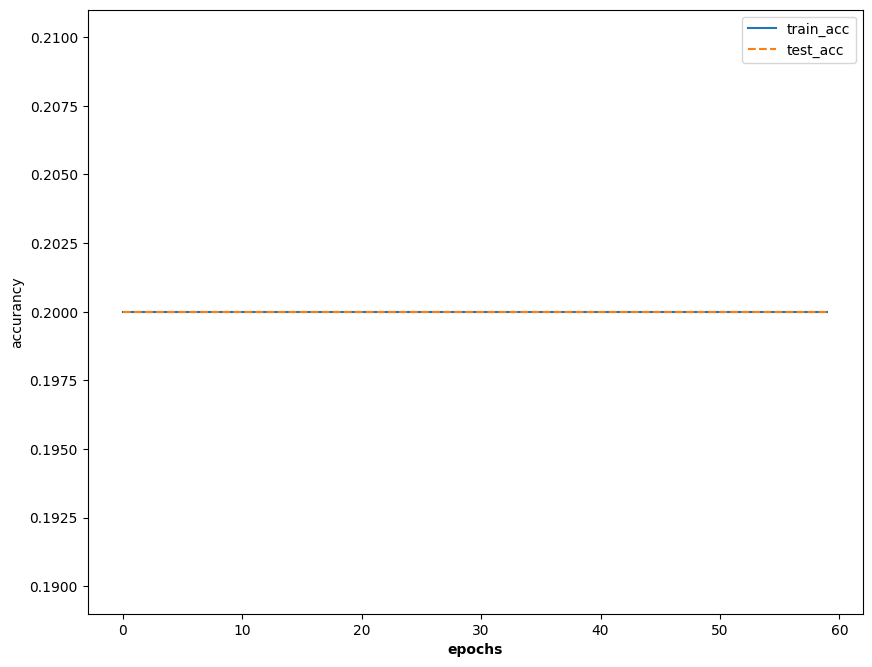

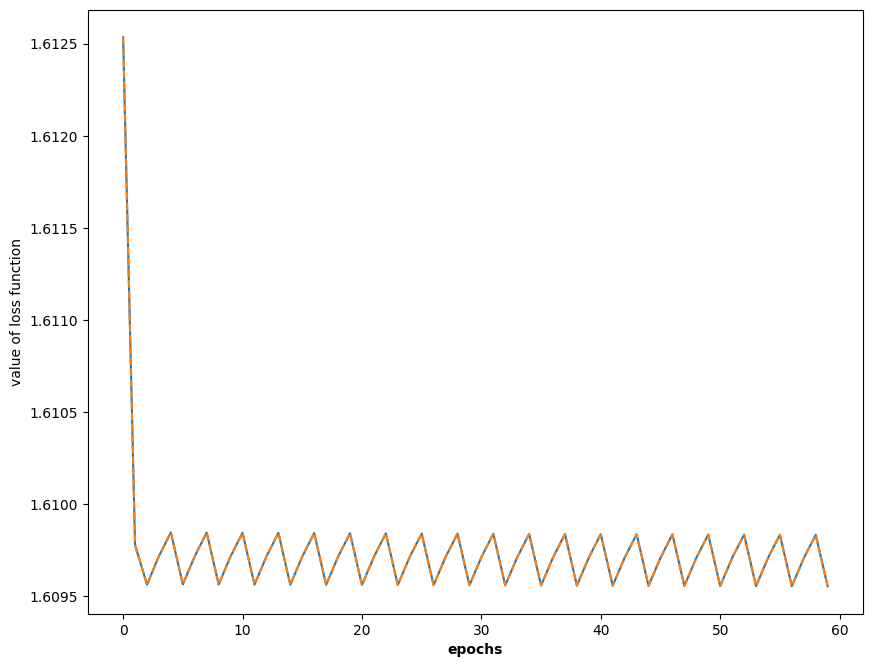

In [83]:
# 1(b) plot
import matplotlib.pyplot as plt
x=range(len(train_acc_list))
y1=train_acc_list
y2=test_acc_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_acc')
plt.plot(x,y2,linestyle='--',label='test_acc')
plt.xlabel('epochs', fontweight="bold")
plt.ylabel('accurancy')
plt.legend()
plt.show()
 

# plt loss
x=range(len(train_loss_list))
y1=train_loss_list
y2=test_loss_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_acc')
plt.plot(x,y2,linestyle='--',label='test_acc')
plt.xlabel('epochs', fontweight="bold")
plt.ylabel('value of loss function')
plt.show()

In [84]:
# 1(b) discussion
print("因為把所有權重都設為零，原本2048和512的NODE每個權重都變得一樣，而每個node反向傳播也獲得同一個值，讓node像是只有一個，無法讓model學習，使他準確率無法提升，像是用猜的。")

因為把所有權重都設為零，原本2048和512的NODE每個權重都變得一樣，而每個node反向傳播也獲得同一個值，讓node像是只有一個，無法讓model學習，使他準確率無法提升，像是用猜的。


In [6]:
# 2(a) dropout implement
class HungNet: 
    def __init__(self, init_weights ,init_biases ):
        self.params = {}  # 使用給定權重，分別加入字典
        self.params['W1'] = np.array(init_weights[0])
        self.params['b1'] = np.array(init_biases[0])
        self.params['W2'] = np.array(init_weights[1])
        self.params['b2'] = np.array(init_biases[1])
        self.params['W3'] = np.array(init_weights[2])
        self.params['b3'] = np.array(init_biases[2])


    def predict(self, x):        
        W1, W2 ,W3 = self.params['W1'], self.params['W2'], self.params['W3']  
        b1, b2 ,b3 = self.params['b1'], self.params['b2'], self.params['b3']
        a1 = np.dot(x, W1) + b1        # 使用字典中的權重算forward
        z1 = relu(a1)        
        a2 = np.dot(z1, W2) + b2        
        z2 = relu(a2)  # 在testing phase不須加dropout
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)
        return y
    
       
    def gradient(self, x, t):
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']
        
        grads = {} 
        
        # feed forward 先算forward取得各節點參數值
        dprate = 0.2 # Dropout rate
 
        batch_num = x.shape[0]   
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        d1 = np.random.rand(z1.shape[0],z1.shape[1])<(1-dprate) # 0~1隨機數，小於0.8都是true，相當於每個點留下機率0.8%
        z1 = z1*d1 # 使z1 dropout
        a2 = np.dot(z1, W2) + b2
        z2 = relu(a2)
        d2 = np.random.rand(z2.shape[0],z2.shape[1])<(1-dprate) # 同理
        z2 = z2*d2
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)
        
       
        # backward 回傳無差，因被dropout的node回傳值是零
        dy = (y - t) / batch_num 
        
        grads['W3'] = np.dot(z2.T, dy) # 作法與前面相同
        grads['b3'] = np.sum(dy, axis=0)
        dz2 = np.dot(dy, W3.T)
        da2 = relu_grad(z2) * dz2   
        grads['W2'] = np.dot(z1.T, da2)
        grads['b2'] = np.sum(da2, axis=0)        
        dz1 = np.dot(da2, W2.T)
        da1 = relu_grad(z1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)
        return grads


    def loss(self, x, t):
        y = self.predict(x) # x:train_data, t:t
        
        return cross_entropy(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

In [7]:
# 2(a) train
#%% exe training
train_loss_list=[] # 設定空list用以畫圖
test_loss_list=[]
train_acc_list=[]
test_acc_list=[]
epoch=0
#%%
# Hyperparameters Settings 使用題目給定要求超參數
iters_num = 150*20 
train_size = 30000
batch_size= 200
learning_rate=0.001
network = HungNet(init_weights,init_biases) # 傳入class的是給定權重和bias
iter_per_epoch = 150 # 每個epoch的iterations數
plot_iter = 50 # 每50iterations取一次值畫圖
for i in range(iters_num):
    batch_mask=[]
    for j in range((i%150)*200,(1+(i%150))*200):
        batch_mask.append(j) # 從30000筆拿出200筆
    x_batch=train_x[batch_mask] # (200,784)
    y_batch=train_y[batch_mask] # (200,5)

    grad=network.gradient(x_batch,y_batch) 
 
    for key in ('W1','b1','W2','b2','W3','b3'): # 利用字典改參數
        network.params[key]-=learning_rate * grad[key] # change weights and biases
 
    if (i+1)%plot_iter==0: # 每50 iterations
        if (i+1)%iter_per_epoch==0: # 每150 iterations
          epoch+=1
          print('epoch'+str(epoch))
          if (i+1)==iters_num: # 最後print
              print('epoch '+str(epoch)+': '+' train_acc '+str(train_acc)+', test_acc  '+str(test_acc)+', train_loss  '+str(train_loss)+', test_loss  '+str(test_loss))
        train_loss=network.loss(train_x,train_y)
        test_loss=network.loss(test_x,test_y)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc=network.accuracy(train_x,train_y)
        test_acc=network.accuracy(test_x,test_y)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
model_2a = network.params

epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
epoch10
epoch11
epoch12
epoch13
epoch14
epoch15
epoch16
epoch17
epoch18
epoch19
epoch20
epoch 20:  train_acc 0.9796333333333334, test_acc  0.9748, train_loss  0.3262827910300787, test_loss  0.4061759212689538


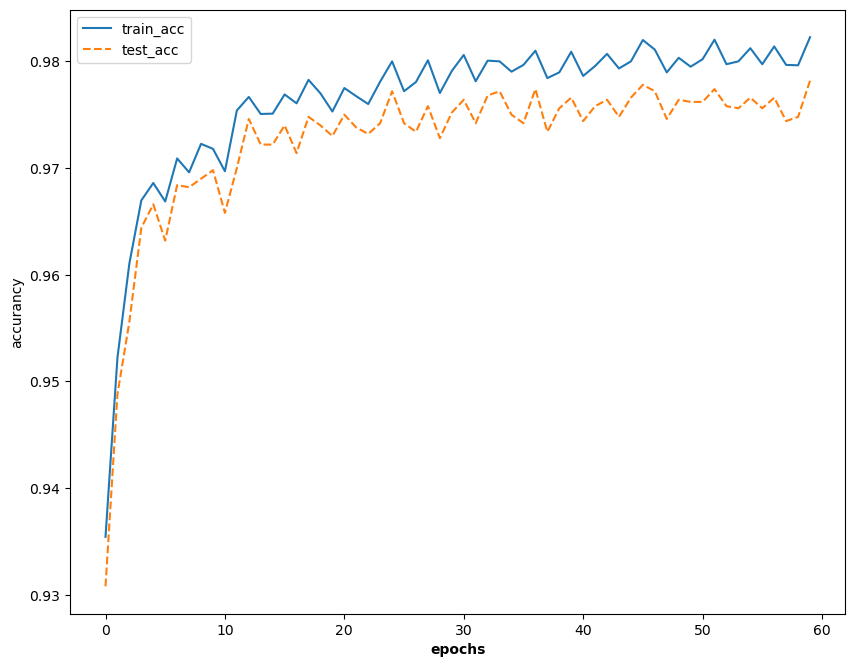

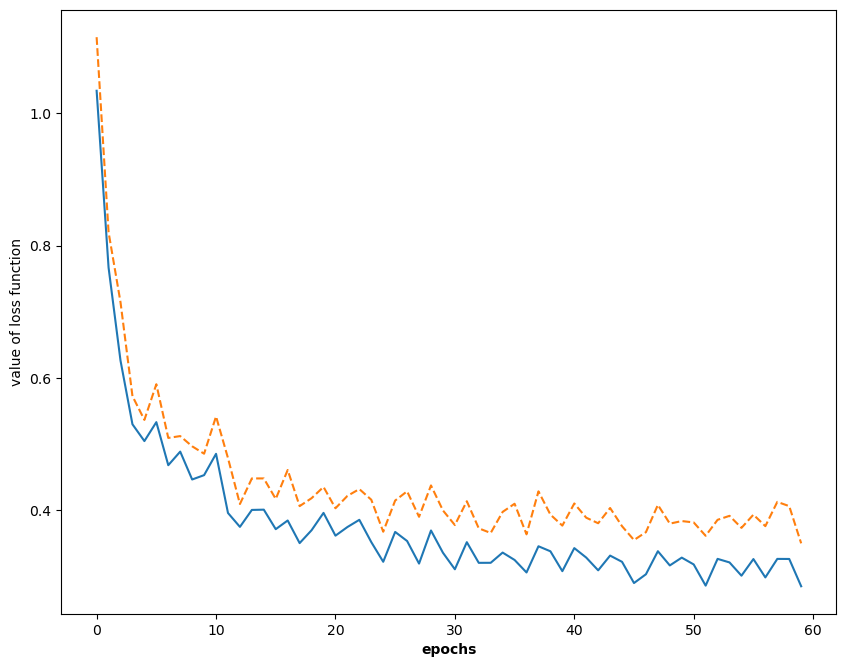

In [8]:
# 2(a) plot
import matplotlib.pyplot as plt
x=range(len(train_acc_list))
y1=train_acc_list
y2=test_acc_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_acc')
plt.plot(x,y2,linestyle='--',label='test_acc')
plt.xlabel('epochs', fontweight="bold")
plt.ylabel('accurancy')
plt.legend()
plt.show()
 

# plt loss
x=range(len(train_loss_list))
y1=train_loss_list
y2=test_loss_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_acc')
plt.plot(x,y2,linestyle='--',label='test_acc')
plt.xlabel('epochs', fontweight="bold")
plt.ylabel('value of loss function')
plt.show()


In [88]:
# 2(b) discussion
print("因為droput主要應用於過擬合overfitting的情況，所以會使測試資料準確率提升時，而最終測試data的準確率會高於1(a)的model，表示有dropout層會有更好的泛化能力，改善原本model測試data準確率上升不了的問題。")

因為droput主要應用於過擬合overfitting的情況，所以會使測試資料準確率提升時，而最終測試data的準確率會高於1(a)的model，表示有dropout層會有更好的泛化能力，改善原本model測試data準確率上升不了的問題。


In [21]:
# 3(a) model
class HungNet: 
    def __init__(self, model_1a ):
        self.params = {}
        self.params['W1'] = model_1a['W1'] # 使用先前model_1a存取好的weights and biases
        self.params['b1'] = model_1a['b1']
        self.params['W2'] = model_1a['W2']
        self.params['b2'] = model_1a['b2']
        self.params['W3'] = model_1a['W3']
        self.params['b3'] = model_1a['b3']


    def predict(self, x):        
        W1, W2 ,W3 = self.params['W1'], self.params['W2'], self.params['W3']  
        b1, b2 ,b3 = self.params['b1'], self.params['b2'], self.params['b3']
        a1 = np.dot(x, W1) + b1        
        z1 = relu(a1)        
        a2 = np.dot(z1, W2) + b2        
        z2 = relu(a2)
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)
        return y
    
       
    def gradient(self, x, t):
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']
        
        grads = {} 
        
        # feed forward    
        batch_num = x.shape[0]   
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) + b2
        z2 = relu(a2)
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)     
       
        # backward
        dy = (y - t) / batch_num # 這裡與前幾題不同，不需修改字典裡的weights and biases
        dz2 = np.dot(dy, W3.T)
        da2 = relu_grad(z2) * dz2  
        dz1 = np.dot(da2, W2.T)
        da1 = relu_grad(z1) * dz1
        grads = np.dot(da1, W1.T)
        return grads # 只須回傳dx即可



    def loss(self, x, t):
        y = self.predict(x) # x:train_data, t:t
        
        return cross_entropy(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

In [22]:
# 3(a) random generate noise
import numpy as np
noise = np.random.randint(256, size=(256, 784)).astype(float) # 先取隨機整數介於0~255之間，且大小為(256, 784)矩陣。
noise = noise/255 # data處理
noise_original = noise.copy() # 先存一個沒被update過的noise
print(noise.dtype)

float64


In [26]:
# 3(a) train
#%% exe training
train_loss_list=[]
test_loss_list=[]
train_acc_list=[]
test_acc_list=[]
epoch=0
#%%
# Hyperparameters Settings
iters_num = 5
batch_size= 256
learning_rate= 0.1
network = HungNet(model_1a) # 使用model_1a的參數
iter_per_epoch = 1
t = train_y[0:256] #　從train_data裡挑256個label用來訓練，因訓練集也是隨機
for i in range(iters_num):
  grad=(network.gradient(noise, t)) # 回傳dx
  noise -=(learning_rate * grad) # change x
  loss=network.loss(noise, t) #　用noise和label算loss
  epoch+=1
  train_loss_list.append(loss)
  train_acc=network.accuracy(noise,t)
  train_acc_list.append(train_acc)
  print('epoch '+str(epoch)+': '+' train_acc '+str(train_acc)+', train_loss  '+str(loss))

epoch 1:  train_acc 1.0, train_loss  -9.999999505838704e-08
epoch 2:  train_acc 1.0, train_loss  -9.999999505838704e-08
epoch 3:  train_acc 1.0, train_loss  -9.999999505838704e-08
epoch 4:  train_acc 1.0, train_loss  -9.999999505838704e-08
epoch 5:  train_acc 1.0, train_loss  -9.999999505838704e-08


In [25]:
# 3(a) label change
print(t.shape) 
def label_back(x): # 把train_data的label值改成看得懂的種類
  y = []
  dic = {0:'trouser',1:'coat',2:'sandal',3:'bag',4:'ankle boot'}
  for i in range(256):
    for j in range(5):
      if x[i,j] == 1:
        y.append(dic[j])
  
  return y
t_label = label_back(t)
print(t_label[0:10])

(256, 5)
['coat', 'sandal', 'ankle boot', 'coat', 'bag', 'sandal', 'trouser', 'trouser', 'bag', 'ankle boot']


ankle boot


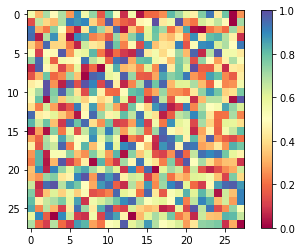

original noise accuracy: 0.1875
original noise predict: [1. 0. 0. 0. 0.]


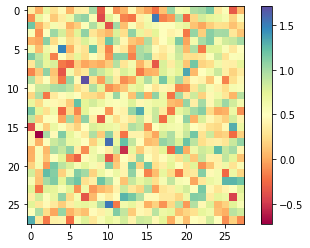

trained noise accuracy: 1.0
trained noise predict: [0. 0. 0. 0. 1.]


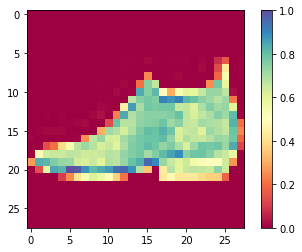

original train data accuracy: [0. 0. 0. 0. 1.]
original train data predict: [0. 0. 0. 0. 1.]


In [27]:
# 3 (a) plot and before after accuracy
data_idx = 21 # 隨機挑一張label值
print(t_label[data_idx]) # 看是哪個類別
# original noise
noise1 = (noise_original[data_idx]).reshape(28,28)
plt.figure()
plt.imshow(noise1, cmap='Spectral')
plt.colorbar()
plt.grid(False)
plt.show()
print('original noise accuracy: '+str(network.accuracy(noise_original, t)))
print('original noise predict: '+str(network.predict(noise_original[data_idx])))
# trained noise
noise2 = (noise[data_idx]).reshape(28,28)
plt.figure()
plt.imshow(noise2, cmap='Spectral')
plt.colorbar()
plt.grid(False)
plt.show()
print('trained noise accuracy: '+str(network.accuracy(noise, t)))
print('trained noise predict: '+str(network.predict(noise[data_idx])))
# original train data
train_data = train_x[data_idx].reshape(28, 28)
plt.figure()
plt.imshow(train_data, cmap='Spectral')
plt.colorbar()
plt.grid(False)
plt.show()
print('original train data accuracy: '+str(network.predict(train_x[data_idx])))
print('original train data predict: '+str(train_y[data_idx]))

In [30]:
# 3(b) discussion and finding
print('可以看出訓練noise準確率上升很快，於第一epoch就100%準確率。')
print('從下圖可以看出noise update前後差距，以及與原本訓練圖片比較，網路看的方式與人不一樣，不會還原出原本的圖片。')

可以看出訓練noise準確率上升很快，於第一epoch就100%準確率。
從下圖可以看出noise update前後差距，網路看的方式與人也不一樣，不會還原出原本的圖片。
